In [1]:
!pip install boruta
!pip install numpy==1.23.1
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import sklearn
from numpy import float16, mean, std
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load Dataset

file_path = "/Users/Sebastiano/data/Clinical_MRI.xlsx"
df = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
df.head()

N° of patients: 27
N° of columns: 969


,Patient,Date of Birth,Gender,Education,Disease duration (months),Age,SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,30084,0,High School,109.5,38.00,0,0.0,1,1,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,26505,0,University,96.0,41.17,13,2.1,0,1,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,Paziente 3,31954,0,University,76.5,32.00,2,0.5,0,1,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
3,Paziente 4,32438,0,University,79.1,31.00,2,0.0,1,1,...,3.0341,0.028616,-6.5858,2.1641,0.020410,2.2997,0.021689,2.0193,0.019045,12.9849
4,Paziente 5,28445,0,high school,42.0,43.00,2,0.4,0,1,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [4]:
# Drop unwanted columns

df = df.drop(['Patient','Date of Birth', 'Gender', 'Education', 'Age','Event'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 962 


In [5]:
# One Hot Encoding for Scores, Antiplatelets and Coagulants, Therapy, NP Event

from sklearn.preprocessing import OneHotEncoder

categ = ['Antiplatelet', 'Anticoagulant', 'Antimalarial', 'Immunosuppressant', 'Biologic']
ohe = OneHotEncoder(categories='auto',sparse=False)
df_enc = ohe.fit_transform(df[categ])
df_enc = pd.DataFrame(df_enc,columns=ohe.get_feature_names_out(categ))
df = pd.concat([df, df_enc], axis=1)
df = df.drop(categ, axis=1)
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Disease duration (months),SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),anti-dsDNA Titre (insert NV here <7 ),Anti-Ro/SSA,Anti-La/SSB,Anti-RNP,anti-Sm,...,Immunosuppressant_Cyclophosphamide,Immunosuppressant_Methotrexate,Immunosuppressant_Mycophenolate,Immunosuppressant_None,Immunosuppressant_azathioprine,Biologic_Belimumab,Biologic_None,Biologic_Rituximab,Biologic_none,Biologic_tocilizumab
0,109.5,0,0.0,1,1,3.0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,96.0,13,2.1,0,1,84.4,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,76.5,2,0.5,0,1,4.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,79.1,2,0.0,1,1,5.0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,42.0,2,0.4,0,1,37.2,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

## Random Forest

In [7]:
def train_test(data: pd.DataFrame):
    
    """Return train-test subjects"""

    np_patients = df.loc[df['NP-SLE'] == 1]
    nonp_patients = df.loc[df['NP-SLE'] == 0]

    print(f"number of neuro patients: {len(np_patients)}")
    print(f"number of non neuro patients: {len(nonp_patients)}")

    number_of_train_nonp = math.floor(0.8 * len(nonp_patients))  # = 
    number_of_train_np = math.floor(0.8 * len(np_patients))  # = 
    train_nonp = nonp_patients[:number_of_train_nonp]
    train_np = np_patients[:number_of_train_np]

    test_nonp = nonp_patients[number_of_train_nonp:]
    test_np = np_patients[number_of_train_np:]

    assert len(train_nonp) + len(test_nonp) == len(nonp_patients)
    assert len(train_np) + len(test_np) == len(np_patients)

    train = pd.concat([train_np, train_nonp])
    test = pd.concat([test_np, test_nonp])

    return train, test

In [8]:
train, test = train_test(df)
X_train = train.loc[:,:]
X_test = test.loc[:,:]
y_train = train.pop("NP-SLE")
y_test = test.pop("NP-SLE")

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

number of neuro patients: 14
number of non neuro patients: 13
Accuracy:  0.6666666666666666


In [9]:
ConfusionMatrix = metrics.confusion_matrix(y_test, y_pred)
print(ConfusionMatrix)

[[2 1]
 [1 2]]


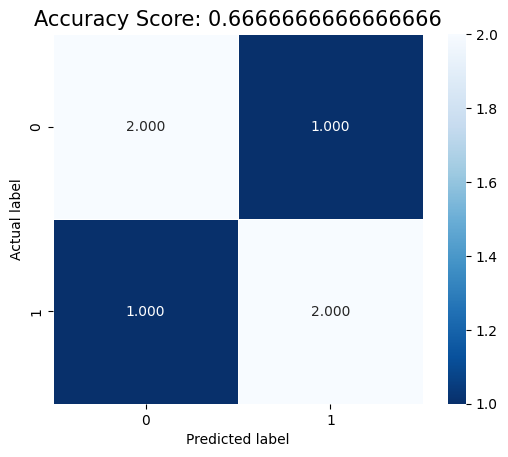

In [10]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

## RF_2

In [6]:
target = df['NP-SLE']
inputs = df.drop(['NP-SLE'], axis = 'columns')
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.20, random_state=10)

In [7]:
from boruta import BorutaPy
np.int = int  # Override np.int with int

x = x_train.values
y = y_train.values
y = y.ravel()

rf_boruta = RandomForestClassifier(n_jobs=-1, class_weight={0: 1, 1: 3}, max_depth=3)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, random_state=42, perc=0.3)
feat_selector.fit(x, y)

cols = inputs.columns[feat_selector.support_]
print("N° of selected features: {}".format(len(cols)))
print(cols)


N° of selected features: 383
Index(['SLEDAI-2k (at the time of NP event)', 'PGA (at the time of fMRI)',
       'anti-dsDNA Titre  (insert NV here <7 )', 'C3 (mg/dl)', 'C4 (mg/dl)',
       'Prednisone  (mg equivalent)', 'Cerebellar Grey Matter volume cm3',
       'Cerebro Spinal Fluid (CSF) volume cm3',
       'Cerebro Spinal Fluid (CSF) volume %', 'Brain (WM+GM) volume %',
       ...
       'PHG right thickness norm.', 'PHG thickness asymmetry',
       'Insular thickness asymmetry', 'AIns thickness asymmetry',
       'PIns total thickness mm', 'PIns right thickness mm',
       'PIns left thickness mm', 'PO right thickness mm',
       'PO right thickness norm.', 'Antiplatelet_None'],
      dtype='object', length=383)


In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Define the class weights based on the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary of class weights
class_weight = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight)

{0: 1.05, 1: 0.9545454545454546}


In [9]:
from sklearn.model_selection import RandomizedSearchCV

# The function to measure the quality of a split
criterion = ['gini', 'entropy']

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=50, num=5)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(14, 30, num=2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6]

max_leaf_nodes = [None, 2, 3, 4, 5, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {
    'criterion': criterion,
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'bootstrap': bootstrap
}

# First create the base model to tune
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight=class_weight
)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=500,
    cv=5
)

# Fit the random search model
rf_random.fit(x_train, y_train)
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'entropy',
 'bootstrap': False}

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, classification_report

rf = RandomForestClassifier(random_state=20,
                            criterion='entropy',
                            n_estimators=20,
                            min_samples_split=8,
                            min_samples_leaf=1,
                            max_leaf_nodes=None,
                            max_features='sqrt',
                            max_depth=30,
                            bootstrap=False)

rf.fit(x_train, y_train)
print("Trained\n")

score_rf = rf.score(x_test, y_test)
print("Random Forest accuracy: ", round(score_rf * 100, 2), "%\n")

y_predicted = rf.predict(x_test)
cm_rf = confusion_matrix(y_test, y_predicted)
print(cm_rf, "\n")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predicted)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('1. The F-1 Score of the model: {}\n'.format(round(f1_score(y_test, y_predicted, average='macro'), 2)))
print('2. The Recall Score of the model: {}\n'.format(round(recall_score(y_test, y_predicted, average='macro'), 2)))
print('3. Classification report:\n{}\n'.format(classification_report(y_test, y_predicted)))
print('4. AUC:\n{}\n'.format(roc_auc))

tn, fp, fn, tp = cm_rf.ravel()

# Sensitivity, hit rate, Recall, or true positive rate
tpr = tp / (tp + fn)
print("Sensitivity (TPR): {}".format(tpr))

# Specificity or true negative rate
tnr = tn / (tn + fp)
print("Specificity (TNR): {}".format(tnr))

# Precision or positive predictive value
ppv = tp / (tp + fp)
print("Precision (PPV): {}".format(ppv))

# Negative predictive value
npv = tn / (tn + fn)
print("Negative Predictive Value (NPV): {}".format(npv))

# False positive rate
fpr = fp / (fp + tn)
print("False Positive Rate (FPR): {}".format(fpr))


Trained

Random Forest accuracy:  83.33 %

[[3 0]
 [1 2]] 

1. The F-1 Score of the model: 0.83

2. The Recall Score of the model: 0.83

3. Classification report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


4. AUC:
0.8333333333333333

Sensitivity (TPR): 0.6666666666666666
Specificity (TNR): 1.0
Precision (PPV): 1.0
Negative Predictive Value (NPV): 0.75
False Positive Rate (FPR): 0.0


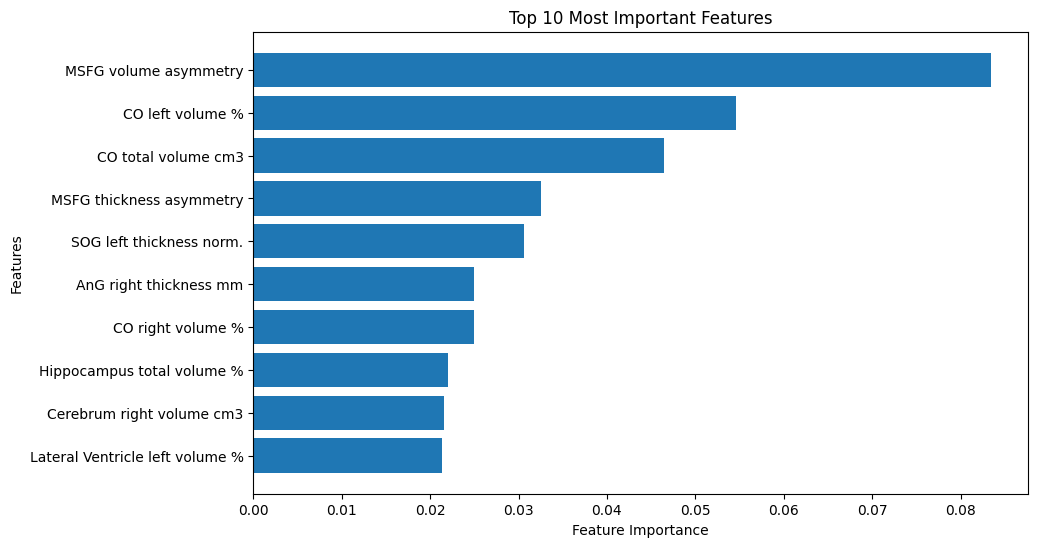

In [13]:
# Get the feature importances
importances = rf.feature_importances_

# Get the indices of the top 10 most important features
top_indices = np.argsort(importances)[-10:]

# Get the names of the top 10 most important features
top_features = inputs.columns[top_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), importances[top_indices], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.show()

## RF_3

In [7]:
target = df['NP-SLE']
inputs = df.drop(['NP-SLE'], axis = 'columns')
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.20, random_state=10)

In [8]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error

# Define the values for l1_ratio and alphas
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
alphas = np.linspace(0.2, 1.0, num=20)

# Initialize lists to store the feature importances
feature_importances_loo = []
feature_importances_loo10 = []

max_iter = 10000

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
for train_index, test_index in loo.split(df):
    x_train, x_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Train the Elastic Net model for different l1_ratio and alphas
    feature_importance = []
    for l1_ratio in l1_ratios:
        for alpha in alphas:
            elastic_net = ElasticNet(l1_ratio=l1_ratio, alpha=alpha, max_iter=max_iter)
            elastic_net.fit(x_train, y_train)
            y_pred = elastic_net.predict(x_test)
            mse = mean_squared_error(y_test, y_pred)
            feature_importance.append(mse)
    
    # Store the feature importances for leave-one-out CV
    feature_importances_loo.append(feature_importance)

# Perform leave-10-out cross-validation
kfold = KFold(n_splits=10)
for train_index, test_index in kfold.split(df):
    x_train, x_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Train the Elastic Net model for different l1_ratio and alphas
    feature_importance = []
    for l1_ratio in l1_ratios:
        for alpha in alphas:
            elastic_net = ElasticNet(l1_ratio=l1_ratio, alpha=alpha, max_iter=max_iter)
            elastic_net.fit(x_train, y_train)
            y_pred = elastic_net.predict(x_test)
            mse = mean_squared_error(y_test, y_pred)
            feature_importance.append(mse)
    
    # Store the feature importances for leave-10-out CV
    feature_importances_loo10.append(feature_importance)

# Compute the average feature importance across cross-validation folds
avg_importance_loo = np.mean(feature_importances_loo, axis=0)
avg_importance_loo10 = np.mean(feature_importances_loo10, axis=0)

# Find the indices of the top 10 most important features
top_indices_loo = np.argsort(avg_importance_loo)[:10]
top_indices_loo10 = np.argsort(avg_importance_loo10)[:10]

# Get the feature names of the top 10 most important features
top_features_loo = df.columns[top_indices_loo]
top_features_loo10 = df.columns[top_indices_loo10]

# Print the top 10 features for leave-one-out CV
print("Top 10 features for leave-one-out CV:")
for i, feature in enumerate(top_features_loo):
    print(f"{i+1}. {feature}")

# Print the top 10 features for leave-10-out CV
print("\nTop 10 features for leave-10-out CV:")
for i, feature in enumerate(top_features_loo10):
    print(f"{i+1}. {feature}")

Top 10 features for leave-one-out CV:
1. Amygdala total volume %
2. Cerebrum GM total volume %
3. Hippocampus total volume cm3
4. Cerebellum WM volume asymmetry
5. Abnormal Appearing White Matter volume %
6. Intracranial Cavity (IC) volume %
7. Intracranial Cavity (IC) volume cm3
8. Abnormal Appearing White Matter volume cm3
9. Cerebellum GM total volume cm3
10. Grey Matter (GM) volume cm3

Top 10 features for leave-10-out CV:
1. Pallidum left volume %
2. Basal Forebrain volume asymmetry
3. Pallidum left volume cm3
4. Accumbens total volume cm3
5. Basal Forebrain left volume %
6. Pallidum right volume %
7. Brainstem volume %
8. Basal Forebrain left volume cm3
9. Cerebellum left volume %
10. Pallidum right volume cm3


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score

# Initialize lists to store the results
actual_labels = []
predicted_probs = []

# Perform nested LOO cross-validation
for subject in range(27):
    # Prepare the training and testing data
    x_train = df.drop(subject, axis=0)
    y_train = target.drop(subject, axis=0)
    x_test = df.iloc[subject]
    y_test = target.iloc[subject]
    
    # Train the random forest model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(x_train, y_train)
    
    # Predict class membership probabilities for the test subject
    y_pred_prob = rf.predict_proba([x_test])
    
    # Append the actual label and predicted probabilities to the lists
    actual_labels.append(y_test)
    predicted_probs.append(y_pred_prob[0][1])  # Probability of NP class

# Calculate performance metrics
auc = roc_auc_score(actual_labels, predicted_probs)
accuracy = accuracy_score(actual_labels, [1 if p > 0.5 else 0 for p in predicted_probs])
sensitivity = recall_score(actual_labels, [1 if p > 0.5 else 0 for p in predicted_probs])
specificity = recall_score(actual_labels, [1 if p > 0.5 else 0 for p in predicted_probs], pos_label=0)

# Print the results
print("AUROC:", auc)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

AUROC: 0.6373626373626373
Accuracy: 0.5555555555555556
Sensitivity: 0.5714285714285714
Specificity: 0.5384615384615384


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


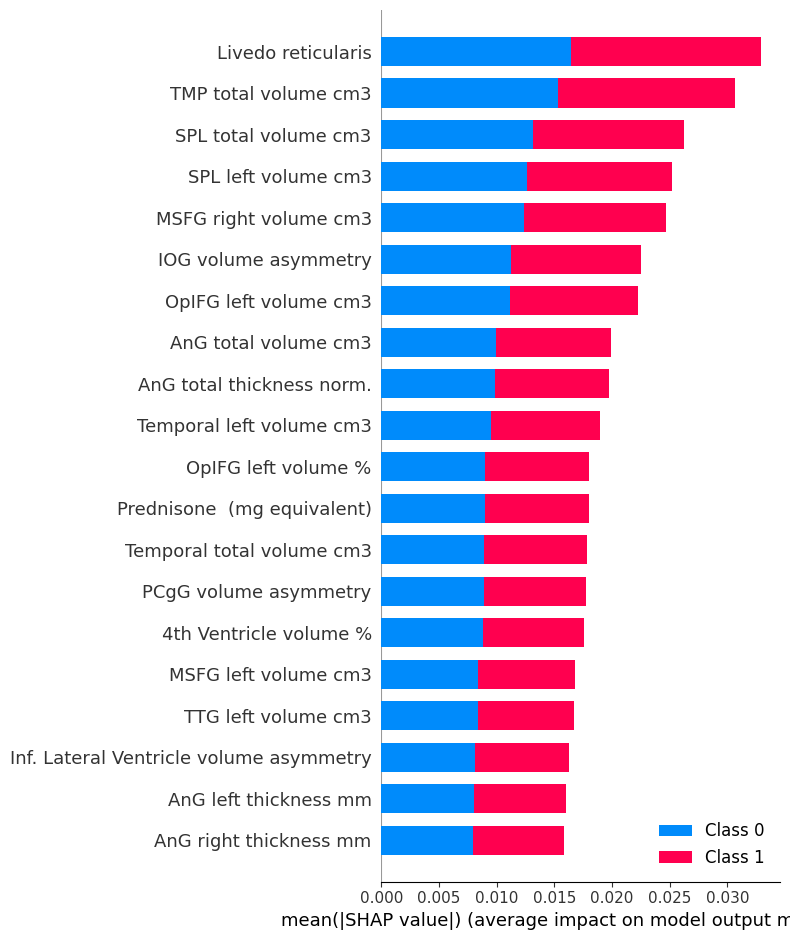

Instance index: 23


IndexError: ignored

In [13]:
import shap
db = df.drop('NP-SLE', axis=1)
# Convert your dataset to numpy array if it's not already in that format
X_1 = db.to_numpy()

# Initialize the SHAP explainer with your random forest model
explainer = shap.Explainer(rf)

# Compute SHAP values for all instances in the dataset
shap_values = explainer.shap_values(X_1)

# (a) Global feature importance plot
shap.summary_plot(shap_values, db.columns)

# (b) Value-specific feature importance plot
# Select a random instance from the dataset
instance_index = np.random.randint(len(X_1))
print("Instance index:", instance_index)  # Debugging line
shap.force_plot(
    explainer.expected_value,
    shap_values[instance_index],
    db.iloc[instance_index, :],
    feature_names=df.columns
)

# (c) Detailed trend plot
# Select a feature to analyze
feature_index = np.random.randint(len(db.columns))
shap.dependence_plot(
    db.columns[feature_index],
    shap_values,
    db,
    feature_names=db.columns
)

plt.show()